## load MNIST dataset

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 500
learning_rate = 1e-3

In [0]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # define which structures might be used
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),  # input channel=1, out channel=16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.cnn2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # input channel=16, out channel=32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        ''' Finaly fullyconnected nn for classification purpose-
        it's usally require some labor to compute the output dim of CNN'''
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        # define your own deep learning architecture here: just like playing LEGO
        out = self.cnn1(x)
        out = self.cnn2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

## Train Convolution Nets

In [3]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):

    # release a batch of data for training one at a time
    for i, (X, y) in enumerate(train_loader):
        # X=input images, y=labels
        X, y= X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = criterion(output, y)
        _, y_pred = torch.max(output.data, 1)

        # compute accuracy
        accuracy = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, total_step, loss.item(), accuracy * 100))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0

    # release a batch of data for validating one at a time
    for images, labels in test_loader:
        X = X.to(device)   # input images
        y = y.to(device)   # labels
        output = model(X)
        _, y_pred = torch.max(output.data, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model parameters (checkpoint)
# torch.save(model.state_dict(), './model.ckpt')

Epoch [1/120], Loss: 0.1036, Accuracy: 97.00%
Epoch [2/120], Loss: 0.0763, Accuracy: 98.00%
Epoch [3/120], Loss: 0.0562, Accuracy: 97.40%
Epoch [4/120], Loss: 0.0368, Accuracy: 99.00%
Epoch [5/120], Loss: 0.0289, Accuracy: 99.00%
Test Accuracy of the model on the 10000 test images: 99.6 %


## Show Images

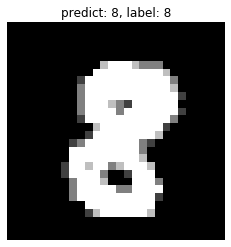

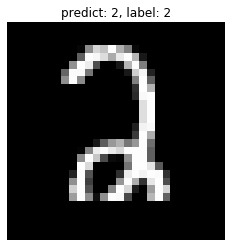

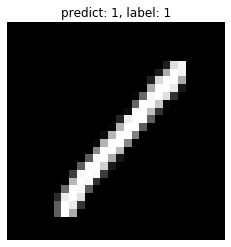

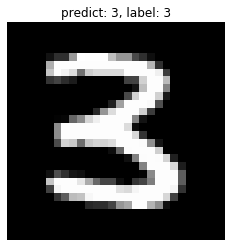

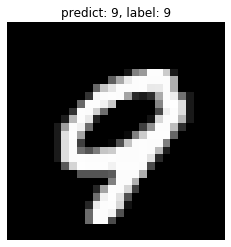

In [31]:
k = np.random.choice(20, 5)
for i in k:
  image, label, pred = X[i].squeeze(0).numpy(), y[i].numpy().item(), y_pred[i].numpy().item()
  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.title('predict: {}, label: {}'.format(pred, label))
  plt.axis('off')
  plt.show()